# Adaboost

In [1]:
# Libraries
import numpy as np
import pandas as pd
from sklearn import tree
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 1. Adaboost Algorithm

We first define the Adaboost algorithm as shown in the algorithm box in the book.

In [2]:
# https://jmlr.org/papers/volume18/15-240/15-240.pdf  # Algorithm 1, page 4
def AdaBoost(X, y, ensemble_size):
    # 1. Initialize weights to all 1
    n = len(y)   # number of data points
    W = np.ones(n) / n
    trees = [None]*ensemble_size   # classifiers
    amount_of_say = [None]*ensemble_size   # weights
    for j in range(ensemble_size):
        # 2a. Fit decision tree classifier with sample weights
        trees[j] = DecisionTreeClassifier(
            criterion="gini",
            max_leaf_nodes=2,
        )
        trees[j].fit(X, y, sample_weight=W)
        # 2b. Calculate "amount of say" of tree
        y_predict = trees[j].predict(X)
        error = ((y != y_predict) * W).sum()
        amount_of_say[j] = 1/2 * np.log((1-error) / error)
        # 2c. Recalculate the sample weights
        # W[y!=y_predict] *= np.exp(amount_of_say[j])   # increase weght of incorrectly classified data points
        # W[y==y_predict] *= np.exp(-amount_of_say[j])  # decrease weght of correctly classified data points
        W = W * np.exp(amount_of_say[j] * (y!=y_predict))
        # 2d. Re-normalize the sample weights
        W = W / W.sum()
    return trees, amount_of_say

## 1. Example Run

We now show an example run of the AdaBoost algorithm


In [3]:
from sklearn.datasets import load_breast_cancer, make_circles
from sklearn.model_selection import train_test_split

# X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X, y = make_circles(n_samples=10000, noise=0.52, factor=0.5, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [4]:
ensemble, amount_of_say = AdaBoost(X_train, y_train, 1000)

In [5]:
def evaluate_ensemble_at_each_iteration(clfs, amount_of_say, X):
    # Evaluate the ensemble at each iteration.
    # Return an array of size_of_ensemble, where each element i contains the predictions
    # for the datapoints made by the ensemble of length i
    F = 0
    predict_iter = [None] * len(clfs)
    for i in range(len(clfs)):
        # Make prediction and wrap it into a pandas Series object
        pred = clfs[i].predict(X)
        pred[pred==0] = -1
        F = F + amount_of_say[i] * pred
        # Array that tells how many ensembles classified each point as possitive
        predict_iter[i] = (F >= 0)
    return predict_iter

predict_train_iter = evaluate_ensemble_at_each_iteration(ensemble, amount_of_say, X_train)
predict_test_iter = evaluate_ensemble_at_each_iteration(ensemble, amount_of_say, X_test)

In [6]:
def evaluate_ensemble_accuracy_at_each_iter(predict_iter, y):
    accuracy = [None] * len(predict_iter)
    for i in range(len(predict_iter)):
        accuracy[i] = (predict_iter[i]==y).mean()
    return accuracy

accuracy_train_iter = evaluate_ensemble_accuracy_at_each_iter(predict_train_iter, y_train)
accuracy_test_iter = evaluate_ensemble_accuracy_at_each_iter(predict_test_iter, y_test)

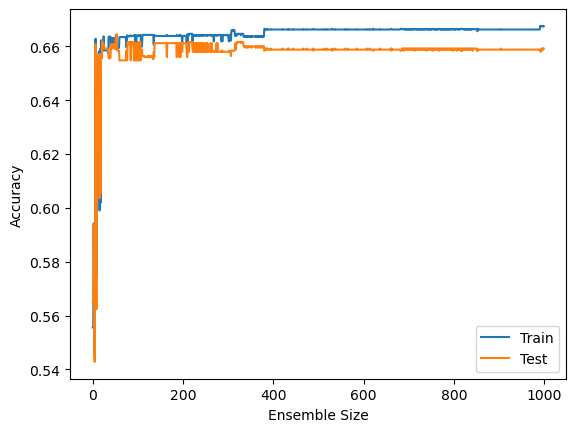

In [7]:
plt.plot(accuracy_train_iter)
plt.plot(accuracy_test_iter)
plt.legend(["Train", "Test"])
plt.ylabel("Accuracy")
plt.xlabel("Ensemble Size");

### `sklearn` adaboost

Compare to sklearn adaboost classifier


In [8]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada_sklearn = AdaBoostClassifier(n_estimators=1000, random_state=0, learning_rate=1)
clf_ada_sklearn.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=1000, random_state=0)

In [10]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html#sphx-glr-auto-examples-ensemble-plot-adaboost-hastie-10-2-py

from sklearn.metrics import zero_one_loss

ada_accuracy_test_iter = np.zeros((clf_ada_sklearn.n_estimators,))
for i, y_pred in enumerate(clf_ada_sklearn.staged_predict(X_test)):
    ada_accuracy_test_iter[i] = 1 - zero_one_loss(y_pred, y_test)

ada_accuracy_train_iter = np.zeros((clf_ada_sklearn.n_estimators,))
for i, y_pred in enumerate(clf_ada_sklearn.staged_predict(X_train)):
    ada_accuracy_train_iter[i] = 1 - zero_one_loss(y_pred, y_train)

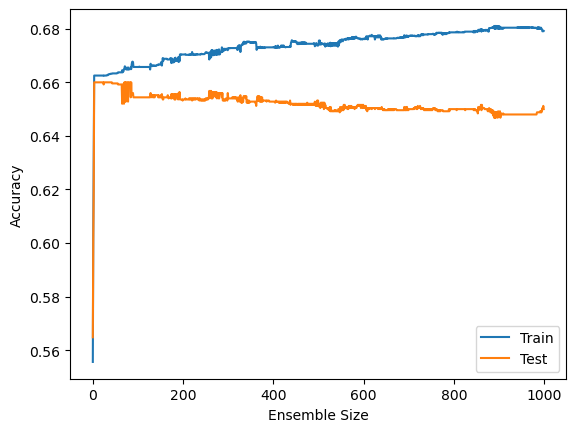

In [11]:
plt.plot(ada_accuracy_train_iter)
plt.plot(ada_accuracy_test_iter)
plt.legend(["Train", "Test"])
plt.ylabel("Accuracy")
plt.xlabel("Ensemble Size");